In [2]:
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')


In [6]:
iris = pd.read_csv("normalized_processed.csv")
iris.head()

,Y,cor_sales_in_vol,cor_sales_in_val,CA_mag,value,ENSEIGNE,VenteConv,Feature
0,0,-0.709506,-0.502125,0.046351,0.341574,0.338037,-0.567069,0
1,0,-0.709506,-0.909596,0.417199,-0.640363,0.405287,-0.845462,0
2,0,0.837993,-0.110600,0.386840,1.573952,0.321567,1.369331,0
3,0,-0.709506,-0.691295,0.364106,-1.145545,0.429692,-0.969528,0
4,0,0.262648,0.794141,1.609802,1.128831,0.338037,0.763839,0


In [11]:
iris.columns

Index(['Y', 'cor_sales_in_vol', 'cor_sales_in_val', 'CA_mag', 'value',
       'ENSEIGNE', 'VenteConv', 'Feature'],
      dtype='object')

In [9]:
class Discretization:
    ''' A process that transforms quantitative data into qualitative data '''
    
    def __init__(cls):
        print('Data discretization process started')
        
    def get_new_intervals(cls, intervals, chi, min_chi):
        ''' To merge the interval based on minimum chi square value '''
        
        min_chi_index = np.where(chi == min_chi)[0][0]
        new_intervals = []
        skip = False
        done = False
        for i in range(len(intervals)):
            if skip:
                skip = False
                continue
            if i == min_chi_index and not done:
                t = intervals[i] + intervals[i+1]
                new_intervals.append([min(t), max(t)])
                skip = True
                done = True
            else:
                new_intervals.append(intervals[i])
        return new_intervals        
        
    def get_chimerge_intervals(cls, data, colName, label, max_intervals):
        '''
            1. Compute the χ 2 value for each pair of adjacent intervals
            2. Merge the pair of adjacent intervals with the lowest χ 2 value
            3. Repeat œ and  until χ 2 values of all adjacent pairs exceeds a threshold
        '''
        
        # Getting unique values of input column
        distinct_vals = np.unique(data[colName])
        
        # Getting unique values of output column
        labels = np.unique(data[label])
        
        # Initially set the value to zero for all unique output column values
        empty_count = {l: 0 for l in labels}
        min_chi = 0
        intervals = [[distinct_vals[i], distinct_vals[i]] for i in range(len(distinct_vals))]
        while len(intervals) > max_intervals:
            chi = []
            for i in range(len(intervals)-1):
                
                # Find chi square for Interval 1
                row1 = data[data[colName].between(intervals[i][0], intervals[i][1])]
                # Find chi square for Interval 2
                row2 = data[data[colName].between(intervals[i+1][0], intervals[i+1][1])]
                total = len(row1) + len(row2)
                
                # Generate Contigency
                count_0 = np.array([v for i, v in {**empty_count, **Counter(row1[label])}.items()])
                count_1 = np.array([v for i, v in {**empty_count, **Counter(row2[label])}.items()])
                count_total = count_0 + count_1
                
                # Find the expected value by the following formula
                # Expected Value → ( Row Sum * Column Sum ) / Total Sum
                expected_0 = count_total*sum(count_0)/total
                expected_1 = count_total*sum(count_1)/total
                chi_ = (count_0 - expected_0)**2/expected_0 + (count_1 - expected_1)**2/expected_1
                
                # Store the chi value to find minimum chi value
                chi_ = np.nan_to_num(chi_)
                chi.append(sum(chi_))
            min_chi = min(chi)
            
            intervals = cls.get_new_intervals(intervals, chi, min_chi)
        print(' Min chi square value is ' + str(min_chi))
        return intervals

In [14]:
max_intervals = 6
obj = Discretization()
interval_list = []
for colName in ['cor_sales_in_vol', 'CA_mag', 'value', 'ENSEIGNE', 'VenteConv']:
    print('\n Interval for', colName)
    intervals = obj.get_chimerge_intervals(
        iris, colName, iris.columns[-1], max_intervals)
    interval_list.append(intervals)
    print(tabulate([[intervals]], tablefmt='fancy_grid'))


Data discretization process started

 Interval for cor_sales_in_vol
 Min chi square value is 30.320704006065274
╒════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ [[-1.1403646023581553, -0.6458719921714208], [-0.5759778561981855, 0.1824347354057059], [0.2626479647762573, 1.047701524801824], [1.072827439087331, 1.5129655587125952], [1.52597976021606, 1.9245737273099528], [1.933071071436924, 2.1672481957059224]] │
╘════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╛

 Interval for CA_mag
 Min chi square value is 46.307300789952535
╒════════════════════════════════════════════════════════

In [16]:
interval_list[0]


[[-1.1403646023581553, -0.6458719921714208],
 [-0.5759778561981855, 0.1824347354057059],
 [0.2626479647762573, 1.047701524801824],
 [1.072827439087331, 1.5129655587125952],
 [1.52597976021606, 1.9245737273099528],
 [1.933071071436924, 2.1672481957059224]]

In [26]:
i = 0
for feature in ['cor_sales_in_vol', 'CA_mag', 'value', 'ENSEIGNE', 'VenteConv']:
    intervals = interval_list[i]
    iris[feature] = pd.cut(iris[feature], bins=len(intervals)-1,
                           labels=range(len(intervals)-1))
    i += 1


In [27]:
iris.head()

,Y,cor_sales_in_vol,cor_sales_in_val,CA_mag,value,ENSEIGNE,VenteConv,Feature
0,0,0,-0.502125,2,2,2,1,0
1,0,0,-0.909596,2,2,3,0,0
2,0,2,-0.110600,2,3,2,4,0
3,0,0,-0.691295,2,1,3,0,0
4,0,2,0.794141,4,3,2,3,0


In [33]:
iris.head()

,Y,cor_sales_in_vol,cor_sales_in_val,CA_mag,value,ENSEIGNE,VenteConv,Feature
0,0,0,42,2,2,2,1,0
1,0,0,25,2,2,3,0,0
2,0,2,58,2,3,2,4,0
3,0,0,34,2,1,3,0,0
4,0,2,96,4,3,2,3,0


In [28]:
data_mdlpc = pd.read_csv("data_after_MDLPC.csv")
data_mdlpc.head()


,Y,cor_sales_in_vol,cor_sales_in_val,CA_mag,value,ENSEIGNE,VenteConv,Feature
0,0,19,42,66,74,0.338037,39,0
1,0,19,25,80,54,0.405287,27,0
2,0,88,58,79,98,0.321567,123,0
3,0,19,34,78,44,0.429692,21,0
4,0,62,96,126,90,0.338037,96,0


In [29]:
iris['cor_sales_in_val'] = data_mdlpc['cor_sales_in_val']

### Trying the models 

- **Logit model**

- **ADL model**

- **Decision tree**

- **Random Forest**

- **Neural network**

- **Gradient Boosting machine**

- **Support Vector Machine**

#### Logit model
The logit model, also known as a logistic regression model, is used for binary classification problems. It estimates the probability of the target variable being a certain class given the independent variables.

In [30]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# load the dataset
df = iris

# split the data into the features(X) and the target(Y)
X = df.drop('Y', axis=1)
Y = df['Y']

# split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

# instantiate the model
logit = LogisticRegression()

# fit the model on the training data
logit.fit(X_train, Y_train)

# make predictions on the test data
Y_pred = logit.predict(X_test)


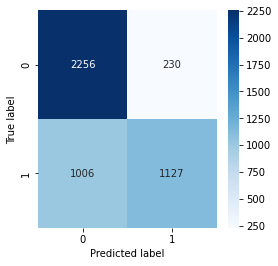

In [31]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(Y_test, Y_pred)


In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return acc, prec, rec, f1


acc, prec, rec, f1 = evaluate_model(Y_test, Y_pred)
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)


Accuracy: 0.7324096124702316
Precision: 0.8305084745762712
Recall: 0.5283638068448195
F1 Score: 0.6458452722063037


#### ADL model: 
Linear discriminant analysis (LDA) is a method used for classification and dimensionality reduction. It aims to find a linear combination of the independent variables that best separates the different classes of the target variable.

In [34]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [35]:
# instantiate the model
adl = LinearDiscriminantAnalysis()
# fit the model on the training data
adl.fit(X_train, Y_train)
# make predictions on the test data
Y_pred = adl.predict(X_test)


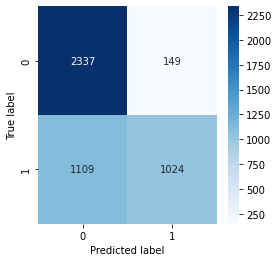

In [36]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(Y_test, Y_pred)


In [37]:
acc, prec, rec, f1 = evaluate_model(Y_test, Y_pred)
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)


Accuracy: 0.7276466767698636
Precision: 0.8729752770673487
Recall: 0.48007501172058137
F1 Score: 0.6194797338173018


#### Decision tree: 
Decision trees are a type of supervised learning algorithm used for both classification and regression problems. They work by recursively partitioning the data into subsets based on the values of the independent variables.

In [38]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the model
dt = DecisionTreeClassifier()
# fit the model on the training data
dt.fit(X_train, Y_train)
# make predictions on the test data
Y_pred = dt.predict(X_test)


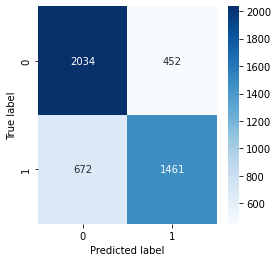

In [39]:
plot_confusion_matrix(Y_test, Y_pred)


In [40]:
acc, prec, rec, f1 = evaluate_model(Y_test, Y_pred)
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)


Accuracy: 0.7566572851266508
Precision: 0.7637219027705175
Recall: 0.6849507735583685
F1 Score: 0.722194760257044


##### We will try to fine-tune the DT model to explore better results 

In [41]:
from sklearn.model_selection import GridSearchCV


In [42]:
# Define the parameter grid to search over
param_grid = {'max_depth': [2, 4, 6, 8, 10],
              'min_samples_split': [2, 4, 6, 8, 10],
              'min_samples_leaf': [1, 2, 4, 6, 8, 10]}
# Instantiate the GridSearchCV object
grid_search = GridSearchCV(dt, param_grid, cv=5)
# Fit the grid search object to the data
grid_search.fit(X_train, Y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 4, 6, 8, 10],
                         'min_samples_split': [2, 4, 6, 8, 10]})

In [43]:
# Print the best parameters and the best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


Best parameters:  {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 8}
Best score:  0.7639254674038946


In [44]:
# Re-train the model with the best parameters
dt = DecisionTreeClassifier(max_depth=grid_search.best_params_["max_depth"],
                            min_samples_split=grid_search.best_params_[
                                "min_samples_split"],
                            min_samples_leaf=grid_search.best_params_["min_samples_leaf"])
dt.fit(X_train, Y_train)

Y_pred = dt.predict(X_test)

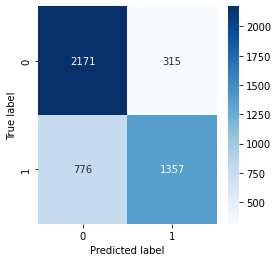

In [45]:
plot_confusion_matrix(Y_test, Y_pred)


In [46]:
acc, prec, rec, f1 = evaluate_model(Y_test, Y_pred)
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)


Accuracy: 0.7638016886772029
Precision: 0.8116028708133971
Recall: 0.6361931551804969
F1 Score: 0.7132720105124836


##### It turns out that we gote worse results when we tried to tune the model, that might be due to several reasons such as : 

- **Overfitting**: The model may be overfitting on the training data and therefore may not generalize well to unseen test data.

- **Insufficient data**: The dataset may be too small to support the complexity of the model, and thus the model is not able to learn the underlying patterns of the data.

- **Poorly chosen parameter grid**: The parameters searched in the grid search may not be the best for the specific dataset and problem.

- **Correlated features**: The features used in the model may be correlated with each other, this could lead to poor generalization as the model would be based on redundant information.

#### Random Forest:
 A random forest is an ensemble of decision trees. The idea is to average the predictions of many trees to reduce the variance and increase the accuracy of the model.

In [47]:
from sklearn.ensemble import RandomForestClassifier
# instantiate the model
rf = RandomForestClassifier()

# fit the model on the training data
rf.fit(X_train, Y_train)
# make predictions on the test data
Y_pred = rf.predict(X_test)


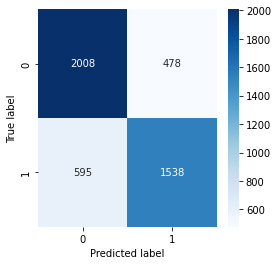

In [48]:
plot_confusion_matrix(Y_test, Y_pred)


In [49]:
acc, prec, rec, f1 = evaluate_model(Y_test, Y_pred)
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)


Accuracy: 0.767698636068413
Precision: 0.7628968253968254
Recall: 0.7210501640881388
F1 Score: 0.7413834658953966


#### Neural network: 
Neural networks are a type of machine learning model that are inspired by the structure and function of the human brain. They can be used for a wide range of problems, including classification and regression.

In [50]:
from keras.models import Sequential
from keras.layers import Dense


2023-01-20 16:12:05.014968: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-20 16:12:05.736590: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-20 16:12:05.736622: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-20 16:12:07.925140: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [51]:
# Create the model
model = Sequential()
model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))


2023-01-20 16:12:09.969031: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-20 16:12:09.969550: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-20 16:12:09.969627: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sheikhPC): /proc/driver/nvidia/version does not exist
2023-01-20 16:12:09.971353: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [58]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])


In [59]:
# fit the model to the training data
history = model.fit(X_train, Y_train, epochs=10,
                    batch_size=32, validation_data=(X_test, Y_test))


Epoch 1/10
578/578 [==============================] - 3s 4ms/step - loss: 0.6069 - accuracy: 0.6731 - val_loss: 0.5571 - val_accuracy: 0.7075
Epoch 2/10
578/578 [==============================] - 2s 3ms/step - loss: 0.5585 - accuracy: 0.7137 - val_loss: 0.5377 - val_accuracy: 0.7244
Epoch 3/10
578/578 [==============================] - 2s 3ms/step - loss: 0.5466 - accuracy: 0.7164 - val_loss: 0.5429 - val_accuracy: 0.7173
Epoch 4/10
578/578 [==============================] - 2s 3ms/step - loss: 0.5395 - accuracy: 0.7222 - val_loss: 0.5343 - val_accuracy: 0.7391
Epoch 5/10
578/578 [==============================] - 2s 4ms/step - loss: 0.5387 - accuracy: 0.7273 - val_loss: 0.5400 - val_accuracy: 0.7335
Epoch 6/10
578/578 [==============================] - 2s 3ms/step - loss: 0.5362 - accuracy: 0.7271 - val_loss: 0.5295 - val_accuracy: 0.7333
Epoch 7/10
578/578 [==============================] - 2s 3ms/step - loss: 0.5338 - accuracy: 0.7265 - val_loss: 0.5542 - val_accuracy: 0.7168
Epoch 

In [60]:
# evaluate the model's performance on the test data
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)


145/145 [==============================] - 0s 2ms/step - loss: 0.5254 - accuracy: 0.7432
Test accuracy: 0.7432344555854797


In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix_nn(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    Y_pred = (Y_pred > 0.5)  # threshold of 0.5 for binary classification
    conf_matrix = confusion_matrix(Y_test, Y_pred)

    plt.imshow(conf_matrix, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks([0, 1], ["Negative", "Positive"])
    plt.yticks([0, 1], ["Negative", "Positive"])
    plt.colorbar()
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, conf_matrix[i, j],
                     ha="center", va="center", color="w")
    plt.show()


145/145 [==============================] - 0s 2ms/step


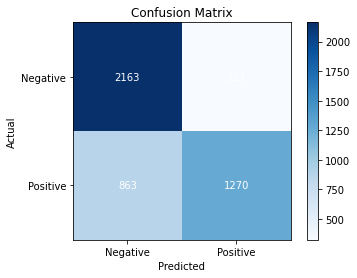

In [62]:
plot_confusion_matrix_nn(model, X_test, Y_test)


In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def evaluate_model_nn(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    Y_pred = (Y_pred > 0.5)  # threshold of 0.5 for binary classification
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    print("Accuracy: {:.2f}".format(accuracy))
    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))


In [64]:
evaluate_model_nn(model, X_test, Y_test)


145/145 [==============================] - 0s 2ms/step
Accuracy: 0.74
Precision: 0.80
Recall: 0.60
F1 Score: 0.68


#### Gradient Boosting machine :
 Gradient Boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.

In [65]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = onehot_encoder.fit_transform(X_train)
X_test_encoded = onehot_encoder.transform(X_test)


In [66]:
from xgboost import XGBClassifier

# Create the GBM model
gbm = XGBClassifier()

# Fit the model to the training data
gbm.fit(X_train_encoded, Y_train)

# Make predictions on the test data
Y_pred = gbm.predict(X_test_encoded)


In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def evaluate_xgboost(model, X_test, Y_test):
    Y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    print("Accuracy: {:.2f}".format(accuracy))
    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))


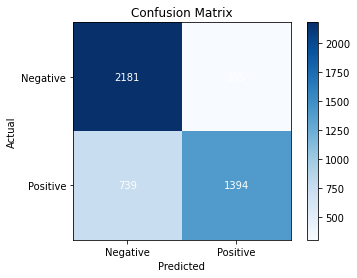

In [73]:
plot_confusion_matrix_nn(gbm, X_test_encoded, Y_test)


In [68]:
evaluate_xgboost(gbm, X_test_encoded, Y_test)


Accuracy: 0.77
Precision: 0.82
Recall: 0.65
F1 Score: 0.73


##### We wanted to test if tuning the model would give better result but we didnt run this step here because it requires expensive processing power 

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Create the GridSearchCV object
xgb_grid = GridSearchCV(gbm, param_grid, cv=5)

# Fit the GridSearchCV object to the data
xgb_grid.fit(X_train_encoded, Y_train)

# Print the best parameters and the best score
print("Best parameters: ", xgb_grid.best_params_)
print("Best score: ", xgb_grid.best_score_)

best_params = xgb_grid.best_params_
best_score = xgb_grid.best_score_

# Next, re-initialize the model using the best parameters
xgb_best = XGBClassifier(**best_params)

# Re-train the model on the entire training dataset
xgb_best.fit(X_train, Y_train)

# Make predictions on the test data
Y_pred = xgb_best.predict(X_test)


In [ ]:
evaluate_xgboost(xgb_best, X_test_encoded, Y_test)


#### Support Vector Machine: 
SVM is a supervised learning algorithm that can be used for classification or regression problems. It works by finding the optimal hyperplane that maximally separates the different classes of the target variable.

In [70]:
from sklearn.svm import SVC

# Initialize the SVM model
svm = SVC()

# Fit the SVM model to the training data
svm.fit(X_train, Y_train)

# Make predictions on the test data
Y_pred = svm.predict(X_test)


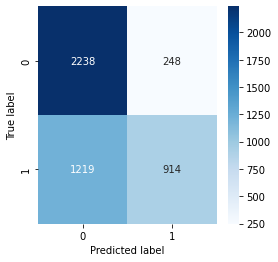

In [71]:
def plot_confusion_matrix(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plot_confusion_matrix(Y_test, Y_pred)


In [72]:
acc, prec, rec, f1 = evaluate_model(Y_test, Y_pred)
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)


Accuracy: 0.6823987876163672
Precision: 0.7865748709122203
Recall: 0.4285044538209095
F1 Score: 0.5547799696509863


In [ ]:
### 
#TODO : We already tried doing MDLPC using an entropy based approach
#TODO : We need to try doing MDLPC using a Gini based approach or Chi-squared MDLPC
